# Fraud Detection Model Notebook

## Introduction

This notebook demonstrates the step-by-step development of a fraud detection system. It covers synthetic data generation, feature engineering, model training, evaluation, and insights.

### **1. Import Libraries**

The necessary libraries are imported to support data manipulation, visualization, and machine learning.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from faker import Faker
from collections import Counter
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,  roc_auc_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

### **2. Synthetic Data Generation**
Here, synthetic data is generated to simulate real-world financial transactions. This data includes attributes like account IDs, transaction amounts, and timestamps. The `Faker` library ensures the data appears realistic.

In [2]:
fake = Faker()
np.random.seed(42)
Faker.seed(42)

In [3]:
# number of rows
num_rows = 1_000_000
num_unique_accounts = int(num_rows * 0.2)
num_unique_receivers = int(num_rows * 0.1)

# Unique account and receiver IDs
account_ids = [fake.random_number(digits=10, fix_len=True) for _ in range(num_unique_accounts)]
receiver_ids = [fake.random_number(digits=10, fix_len=True) for _ in range(num_unique_receivers)]

### **Creating the dataset**

**Columns the data should have:**

- `Transaction ID:` Unique identifier for each transaction.

- `Account ID:` Unique identifier for the account performing the transaction.

- `Account Type:` Indicates if it’s a personal or business account.

- `Account Creation Date:` For calculating the account age.

- `Transaction Amount:` The monetary value of each transaction.

- `Transaction Date and Time:` Exact timestamp of each transaction to identify unusual timings and frequency patterns.

- `Payment Channel:` Specifies the method used (e.g., bank transfer, Deposit, Sport Betting, Airtime).

- `Receiver Account ID:` Unique identifier for the destination account.

- `Transaction Type:` Category of the transaction (e.g., Bank Transfer, Airtime, Deposit, Sport Betting, ).

- `Transaction Status:` Status of the transaction (e.g., success, failure, pending).

- `Daily Transaction Amount:` Cumulative transaction amount per user per day, which can be calculated if not readily available.

- `Total Daily Transactions:` Total number of transactions per user per day, useful for rules based on frequency.

In [4]:
# Data Generation
data = {
    "transaction_id": [fake.uuid4() for _ in range(num_rows)],
    "account_id": np.random.choice(account_ids, num_rows),  # Randomly assign one of the unique account IDs to each transaction
    "account_type": np.random.choice(["Personal", "Business"], num_rows, p=[0.7, 0.3]),
    "account_creation_date": [fake.date_between(start_date='-5y', end_date='today') for _ in range(num_rows)],
    "transaction_amount": np.random.choice(
        [1000, 5000, 10000, 25000, 50000, 100000, 500000, 1000000, 5000000, 7000000],
        num_rows, p=[0.3, 0.25, 0.2, 0.1, 0.05, 0.03, 0.02, 0.03, 0.01, 0.01]
    ),
    "transaction_date_time": [fake.date_time_this_year() for _ in range(num_rows)],
    "payment_type": np.random.choice(["Credit", "Debit"], num_rows),
    "receiver_account_id": np.random.choice(receiver_ids, num_rows),
    "transaction_type": np.random.choice(
        ["Bank Transfer", "Airtime", "Deposit", "Sport Betting"], num_rows, p=[0.6, 0.1, 0.2, 0.1]
    ),
}

In [5]:
# Creating a DataFrame
df = pd.DataFrame(data)

### Uncomment the code below to save the generated dataset to a csv file

In [6]:
df.to_csv('synthetic_data.csv', index=False)

In [7]:
df = pd.read_csv('synthetic_data.csv')
df.head()

,transaction_id,account_id,account_type,account_creation_date,transaction_amount,transaction_date_time,payment_type,receiver_account_id,transaction_type
0,e58a3d35-b950-4c55-b4a2-5542fd7f69a7,5314135070,Personal,2023-12-08,5000,2024-10-10 08:27:12.279631,Debit,5557319056,Bank Transfer
1,ff36b954-4f29-4e15-b81a-3168beec8bea,8031197711,Personal,2023-08-30,100000,2024-11-17 21:16:09.052232,Debit,1761503272,Bank Transfer
2,63e9cd32-5969-4318-b2cf-0a1833cd4a7c,7393181744,Personal,2022-09-27,5000,2024-05-23 03:30:06.881631,Credit,1824977975,Bank Transfer
3,1e1a4d9d-21c9-4f26-a61b-2b966e095091,9803688055,Business,2020-03-10,1000000,2024-11-06 16:02:22.045215,Credit,1295209101,Airtime
4,8bb4d557-4376-4163-bd4f-ad78c4748ac4,2507547298,Business,2024-06-18,10000,2024-03-18 16:47:10.072540,Credit,2892613049,Bank Transfer


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   transaction_id         1000000 non-null  object
 1   account_id             1000000 non-null  int64 
 2   account_type           1000000 non-null  object
 3   account_creation_date  1000000 non-null  object
 4   transaction_amount     1000000 non-null  int64 
 5   transaction_date_time  1000000 non-null  object
 6   payment_type           1000000 non-null  object
 7   receiver_account_id    1000000 non-null  int64 
 8   transaction_type       1000000 non-null  object
dtypes: int64(3), object(6)
memory usage: 68.7+ MB


In [9]:
df.describe()

,account_id,transaction_amount,receiver_account_id
count,1.000000e+06,1.000000e+06,1.000000e+06
mean,5.501144e+09,1.711166e+05,5.493252e+09
std,2.596960e+09,8.628293e+05,2.603085e+09
min,1.000015e+09,1.000000e+03,1.000072e+09
25%,3.253642e+09,1.000000e+03,3.234954e+09
50%,5.510231e+09,5.000000e+03,5.485027e+09
75%,7.746867e+09,1.000000e+04,7.747979e+09
max,9.999992e+09,7.000000e+06,9.999966e+09


### **3. Feature Engineering Based on KENAM rules**

Feature engineering is critical for extracting meaningful patterns from the data. This section adds features like account age, daily transaction totals, and transaction frequency.

In [11]:
# converting datetimes
df['account_creation_date'] = pd.to_datetime(df['account_creation_date'])
df['transaction_date_time'] = pd.to_datetime(df['transaction_date_time'])

# amounts to float
df['transaction_amount'] = df['transaction_amount'].astype(float)

# Account age
df["account_age_days"] = (pd.to_datetime("today") - pd.to_datetime(df["account_creation_date"])).dt.days

# Daily transaction amount for each account
df['transaction_date'] = df['transaction_date_time'].dt.date
df["daily_transaction_amount"] = df.groupby(["account_id","transaction_date"])["transaction_amount"].transform("sum")

# Total daily transaction count for each account
df["total_daily_transactions"] = df.groupby(["account_id","transaction_date"])["transaction_id"].transform("count")

# Transaction frequency and time delta to the same account
df["time_delta_same_account"] = df.groupby(['account_id', 'receiver_account_id'])["transaction_date_time"].diff().fillna(pd.Timedelta(seconds=0))
df["transaction_frequency_same_account"] = df.groupby(['account_id', 'receiver_account_id'])["transaction_id"].transform("count")

# Calculate transaction frequency for each transaction
df["transaction_frequency"] = df.groupby("account_id")["transaction_id"].transform("count")

# previous transaction time
df['previous_transaction_time'] = df.groupby('account_id')['transaction_date_time'].shift(1)

### Creating the function for the target column based on the KENAM rules

In [12]:
def is_suspicious(row):
    # Rule 1: Regulatory Requirements (High value transactions for personal and business accounts)
    if (row['transaction_amount'] >= 5_000_000 and row['account_type'] == 'Personal') or \
       (row['transaction_amount'] >= 10_000_000 and row['account_type'] == 'Business'):
        return 1

    # Rule 2: Frequent Transactions to Same Account over 3 times within 1 hour
    if row['transaction_frequency_same_account'] > 3 and \
       row['time_delta_same_account'] <= pd.Timedelta(hours=1):
        return 1

    # Rule 3: High Total Daily Transaction Amount
    if row['daily_transaction_amount'] > 5_000_000:
        return 1

    # Rule 4: Unusually High Transaction Frequency (exceeds 8 in 1 hour and type is 'Bank Transfer')
    if row['transaction_frequency'] > 8 and row['transaction_type'] == 'Bank Transfer' and \
       row['time_delta_same_account'] <= pd.Timedelta(hours=1):
        return 1

    # Rule 5: Late-Night Bank Transfers (after 1 transaction)
    if row['transaction_date_time'].strftime('%H:%M:%S') >= '23:00:00' and \
       row['transaction_date_time'].strftime('%H:%M:%S') <= '05:00:00' and \
       row['transaction_type'] == 'Bank Transfer':
        if row['previous_transaction_time'] is not None and \
           row['previous_transaction_time'] < row['transaction_date_time']:
            return 1

    # Rule 6: Early-Morning Bank Transfers with Amounts over 49,000
    if row['transaction_date_time'].strftime('%H:%M:%S') >= '00:00:00' and \
       row['transaction_date_time'].strftime('%H:%M:%S') <= '05:00:00' and \
       row['transaction_type'] == 'Bank Transfer' and row['transaction_amount'] > 49_000:
        return 1

    # Rule 7: New Account Restrictions for Bank Transfers
    if row['account_age_days'] <= 14 and row['transaction_frequency'] > 3 and \
       row['transaction_amount'] > 99_000 and row['transaction_type'] == 'Bank Transfer':
        return 1

    # Rule 8: New Account Restrictions for VAS (Sport Betting)
    if row['account_age_days'] <= 14 and row['transaction_type'] == 'Sport Betting' and \
       row['transaction_amount'] > 30_000:
        recent_sport_betting = df[(df['account_id'] == row['account_id']) &
                                  (df['transaction_type'] == 'Sport Betting') &
                                  (df['transaction_date_time'] >= row['transaction_date_time'] - pd.Timedelta(hours=3))]
        if recent_sport_betting['transaction_id'].count() > 3:
            return 1

    # Rule 9: New Account Restrictions for VAS (Airtime)
    if row['account_age_days'] <= 14 and row['transaction_type'] == 'Airtime' and \
       row['transaction_amount'] > 4_999:
        recent_airtime_purchase = df[(df['account_id'] == row['account_id']) &
                                     (df['transaction_type'] == 'Airtime') &
                                     (df['transaction_date_time'] >= row['transaction_date_time'] - pd.Timedelta(hours=1))]
        if recent_airtime_purchase['transaction_id'].count() > 3:
            return 1

    return 0

In [13]:
# creating the target column
df['is_suspicious'] = df.apply(is_suspicious, axis=1)

In [14]:
df.head()

,transaction_id,account_id,account_type,account_creation_date,transaction_amount,transaction_date_time,payment_type,receiver_account_id,transaction_type,account_age_days,transaction_date,daily_transaction_amount,total_daily_transactions,time_delta_same_account,transaction_frequency_same_account,transaction_frequency,previous_transaction_time,is_suspicious
0,e58a3d35-b950-4c55-b4a2-5542fd7f69a7,5314135070,Personal,2023-12-08,5000.0,2024-10-10 08:27:12.279631,Debit,5557319056,Bank Transfer,381,2024-10-10,5000.0,1,0 days,1,6,NaT,0
1,ff36b954-4f29-4e15-b81a-3168beec8bea,8031197711,Personal,2023-08-30,100000.0,2024-11-17 21:16:09.052232,Debit,1761503272,Bank Transfer,481,2024-11-17,100000.0,1,0 days,1,10,NaT,1
2,63e9cd32-5969-4318-b2cf-0a1833cd4a7c,7393181744,Personal,2022-09-27,5000.0,2024-05-23 03:30:06.881631,Credit,1824977975,Bank Transfer,818,2024-05-23,5000.0,1,0 days,1,3,NaT,0
3,1e1a4d9d-21c9-4f26-a61b-2b966e095091,9803688055,Business,2020-03-10,1000000.0,2024-11-06 16:02:22.045215,Credit,1295209101,Airtime,1749,2024-11-06,1000000.0,1,0 days,1,3,NaT,0
4,8bb4d557-4376-4163-bd4f-ad78c4748ac4,2507547298,Business,2024-06-18,10000.0,2024-03-18 16:47:10.072540,Credit,2892613049,Bank Transfer,188,2024-03-18,10000.0,1,0 days,1,5,NaT,0


### **Class Distribution before SMOTE**

In [15]:
class_counts = df['is_suspicious'].value_counts()
class_counts

is_suspicious
0    889389
1    110611
Name: count, dtype: int64

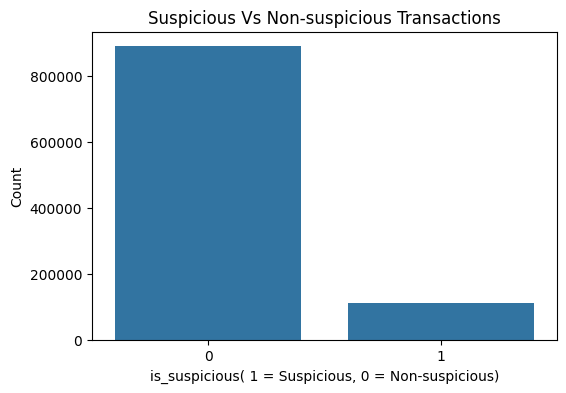

In [16]:
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Suspicious Vs Non-suspicious Transactions')
plt.xlabel('is_suspicious( 1 = Suspicious, 0 = Non-suspicious)')
plt.ylabel('Count')
plt.show()

### **Categorical Encoding**

In [17]:
cat_columns = ['account_type', 'payment_type','transaction_type']

In [18]:
cat_columns = ['account_type', 'payment_type','transaction_type']

df_encoded = pd.get_dummies(df, columns=cat_columns, drop_first=True)
df_encoded.head()

,transaction_id,account_id,account_creation_date,transaction_amount,transaction_date_time,receiver_account_id,account_age_days,transaction_date,daily_transaction_amount,total_daily_transactions,time_delta_same_account,transaction_frequency_same_account,transaction_frequency,previous_transaction_time,is_suspicious,account_type_Personal,payment_type_Debit,transaction_type_Bank Transfer,transaction_type_Deposit,transaction_type_Sport Betting
0,e58a3d35-b950-4c55-b4a2-5542fd7f69a7,5314135070,2023-12-08,5000.0,2024-10-10 08:27:12.279631,5557319056,381,2024-10-10,5000.0,1,0 days,1,6,NaT,0,True,True,True,False,False
1,ff36b954-4f29-4e15-b81a-3168beec8bea,8031197711,2023-08-30,100000.0,2024-11-17 21:16:09.052232,1761503272,481,2024-11-17,100000.0,1,0 days,1,10,NaT,1,True,True,True,False,False
2,63e9cd32-5969-4318-b2cf-0a1833cd4a7c,7393181744,2022-09-27,5000.0,2024-05-23 03:30:06.881631,1824977975,818,2024-05-23,5000.0,1,0 days,1,3,NaT,0,True,False,True,False,False
3,1e1a4d9d-21c9-4f26-a61b-2b966e095091,9803688055,2020-03-10,1000000.0,2024-11-06 16:02:22.045215,1295209101,1749,2024-11-06,1000000.0,1,0 days,1,3,NaT,0,False,False,False,False,False
4,8bb4d557-4376-4163-bd4f-ad78c4748ac4,2507547298,2024-06-18,10000.0,2024-03-18 16:47:10.072540,2892613049,188,2024-03-18,10000.0,1,0 days,1,5,NaT,0,False,False,True,False,False


In [19]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column                              Non-Null Count    Dtype          
---  ------                              --------------    -----          
 0   transaction_id                      1000000 non-null  object         
 1   account_id                          1000000 non-null  int64          
 2   account_creation_date               1000000 non-null  datetime64[ns] 
 3   transaction_amount                  1000000 non-null  float64        
 4   transaction_date_time               1000000 non-null  datetime64[ns] 
 5   receiver_account_id                 1000000 non-null  int64          
 6   account_age_days                    1000000 non-null  int64          
 7   transaction_date                    1000000 non-null  object         
 8   daily_transaction_amount            1000000 non-null  float64        
 9   total_daily_transactions            1000000 non-null  int6

### **4. Model Training**

The prepared data is split into training and testing sets, scaled, and passed into machine learning models. Two models are used: `Logistic Regression` for baseline and `XGBoost` for advanced analysis.

In [20]:
X = df_encoded.drop(columns=['is_suspicious','transaction_id', 'time_delta_same_account','transaction_date', 'previous_transaction_time','account_creation_date', 'transaction_date_time'])
y = df_encoded['is_suspicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Scaling features to standardize their ranges**

In [21]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Addressing class imbalance using SMOTE (Synthetic Minority Oversampling Technique)**

In [22]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

Class distribution after SMOTE: Counter({0: 711501, 1: 711501})


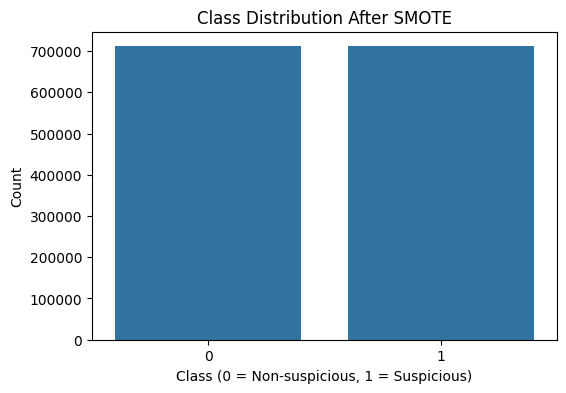

In [23]:
# Check the class distribution after SMOTE
smote_class_counts = Counter(y_train_resampled)
print("Class distribution after SMOTE:", smote_class_counts)

# Plot class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.barplot(x=list(smote_class_counts.keys()), y=list(smote_class_counts.values()))
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class (0 = Non-suspicious, 1 = Suspicious)')
plt.ylabel('Count')
plt.show()

### **Logistic Regression Model**
This model provides a simple and interpretable baseline.

In [ ]:
log_model = LogisticRegression()
log_model.fit(X_train_resampled, y_train_resampled)


# Evaluating Logistic Regression
y_pred_log = log_model.predict(X_test_scaled)
logreg_auc = roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1])

print(logreg_auc)
print(classification_report(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))

0.9699399194722499
              precision    recall  f1-score   support

           0       0.99      0.92      0.95    177888
           1       0.57      0.92      0.71     22112

    accuracy                           0.92    200000
   macro avg       0.78      0.92      0.83    200000
weighted avg       0.94      0.92      0.92    200000

[[162898  14990]
 [  1876  20236]]


### **XGBoost Model**
This model is used for advanced analysis due to its ability to handle complex patterns.

In [25]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluating XGBoost
y_pred_xgb = xgb_model.predict(X_test_scaled)
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])

print(xgb_auc)
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

0.9958901705532159
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    177888
           1       0.77      0.94      0.85     22112

    accuracy                           0.96    200000
   macro avg       0.88      0.95      0.91    200000
weighted avg       0.97      0.96      0.96    200000

[[171785   6103]
 [  1298  20814]]


In [26]:
# Evaluating XGBoost (recall)
rec = recall_score(y_test, y_pred_xgb)
print(rec)

0.9412988422575976


In [27]:
# Save the best model (based on AUC score)
if logreg_auc > xgb_auc:
    best_model = logreg
    best_model_name = 'logreg_model_1.pkl'
else:
    best_model = xgb_model
    best_model_name = 'xgb_model_1.pkl'

# Save the best model using joblib
import joblib
joblib.dump(best_model, best_model_name)

['xgb_model_1.pkl']

## **Conclusion**

This notebook demonstrates the process of building a robust fraud detection system from scratch. Synthetic data generation allowed us to simulate real-world scenarios, and feature engineering enhanced the models' ability to identify suspicious activities. Logistic Regression provided a strong baseline, while XGBoost excelled with its ability to detect complex patterns, achieving an `AUC of 0.99 and a recall of 94%.`

The model's performance highlights the importance of feature engineering and the effectiveness of ensemble methods in fraud detection. However, it's crucial to note that fraud detection is an ongoing challenge, and the model's performance may degrade over time due to evolving fraud techniques. Regular model retraining and monitoring are essential to maintain its effectiveness.

Future directions include deploying the model in a real-time system for continuous monitoring and extending the dataset to simulate more diverse fraud scenarios.

By continuously incorporating feedback and improving the model, this approach can adapt to evolving fraud patterns and remain effective over time.
